In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [65]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import os
%matplotlib inline

<class 'numpy.ndarray'>


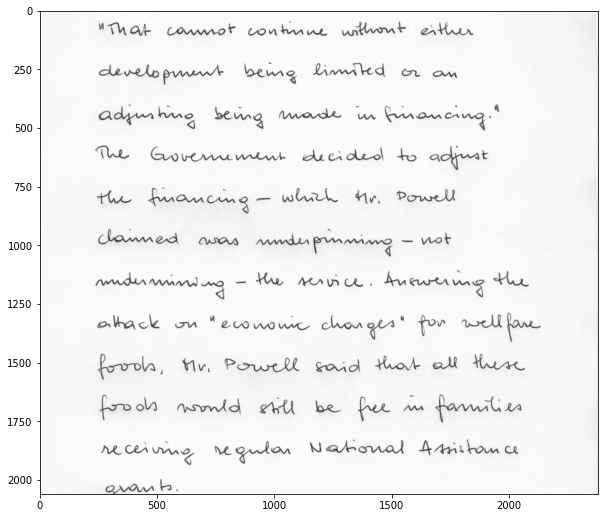

In [66]:
filename = '../input/iam-handwritten-forms-dataset/data/020/a01-132.png'

# Load in Grayscale
img = cv2.imread(filename)
img = img[720:2780, 100:3000]

# The underlying representation is a numpy array!
print(type(img))

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

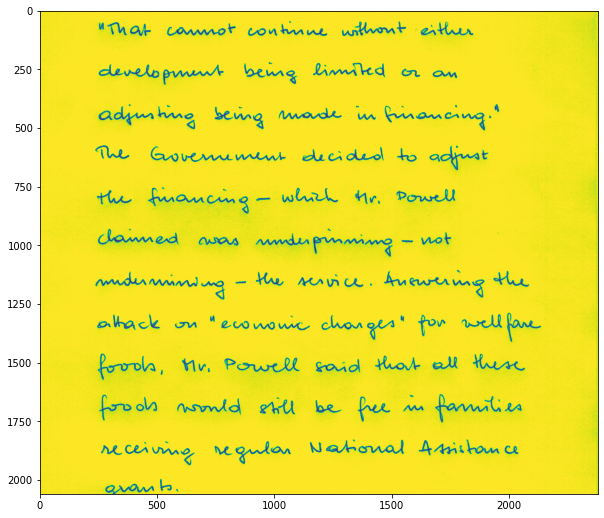

In [67]:
#import image
#image = cv2.imread('a01-000u.png')
#cv2.imshow('orig',image)
#cv2.waitKey(0)

#grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(gray)

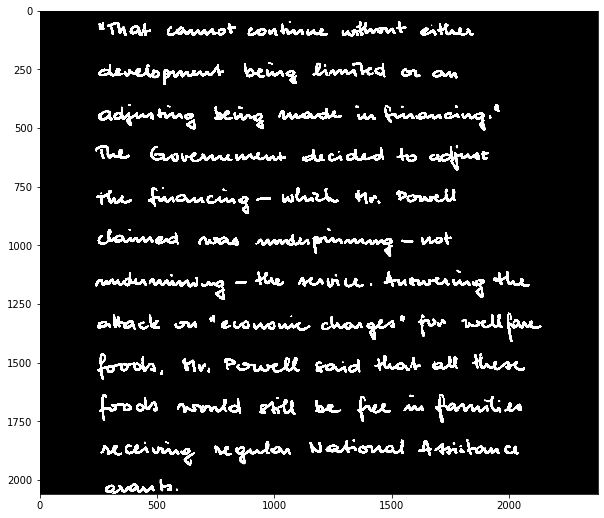

In [68]:
#binary
ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap='gray', vmax=1, vmin=0)

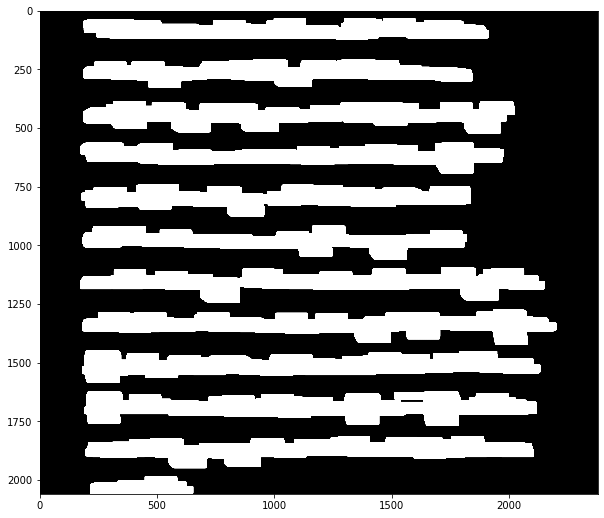

In [69]:
#dilation
kernel = np.ones((25,130), np.uint8)
img_dilation = cv2.dilate(thresh, kernel, iterations=1)
plt.figure(figsize=(10,10))
plt.imshow(img_dilation, cmap='gray', vmax=1, vmin=0)

(2060, 2379, 3)
[[37, 188, 1723, 86], [211, 187, 1656, 118], [390, 187, 1834, 133], [565, 173, 1803, 128], [743, 180, 1655, 134], [920, 1163, 138, 30], [922, 184, 1633, 139], [1096, 174, 1975, 147], [1278, 181, 2019, 145], [1452, 183, 1948, 132], [1625, 191, 1926, 141], [1818, 197, 1906, 130], [1987, 216, 435, 73]]


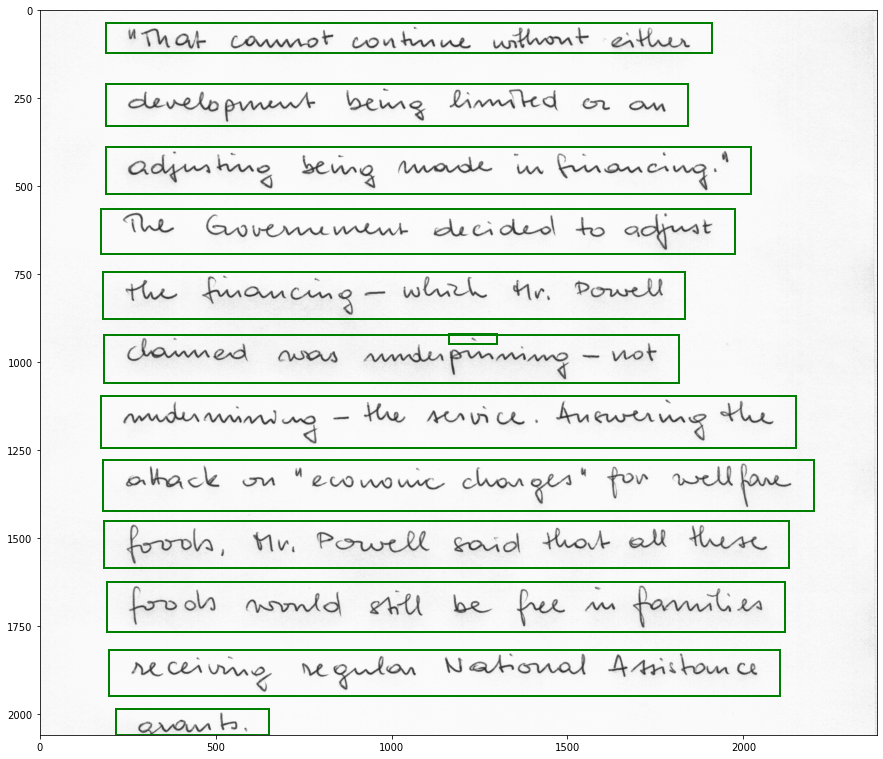

In [71]:
#find contours
ctrs,hier = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#sort contours from left to right and top to bottom
#sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
#it only sorts by y position of the bbox. to sort by x and y you'd use:
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1] * img.shape[1] )

plt.figure(figsize=(15,15))
current_axis = plt.gca()

lst = []

for i, ctr in enumerate(sorted_ctrs):
    sub_list = []
    # Get bounding box
    x, y, w, h = cv2.boundingRect(ctr)
    sub_list.append(y)
    sub_list.append(x)
    sub_list.append(w)
    sub_list.append(h)
    
    #Getting ROI
    #roi = img[y:y+h, x:x+w]
    
    lst.append(sub_list)
    
    # show ROI
    #plt.imshow(roi)
    current_axis.add_patch(Rectangle((x, y), w, h, edgecolor = 'g', fill=False, linewidth=2)) 
    #crop_img = roi
    #cv2.rectangle(img,(x,y),( x + w, y + h ),(90,0,255),2)
    #cv2.waitKey(0)


print(img.shape)
print(lst)
plt.imshow(img)
#cv2.waitKey(0)
plt.show()

In [ ]:
lst.sort()

os.mkdir(filename[:-4])

for i in range(len(lst)):
      cv2.imwrite(filename[:-4] + '/' + filename[:-4] + '-'+ str(i) + '.jpg', 
                  img[lst[i][0]: lst[i][0] + lst[i][3], lst[i][1]: lst[i][1] + lst[i][2]])

In [8]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [10]:
images = []
labels = []

RECORDS_COUNT = 30000

In [11]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [16]:
with open('../input/iam-dataset/IAM/words.txt') as f:
    contents = f.readlines()[18:22539]

lines = [line.strip() for line in contents] 
lines[1]

'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE'

In [17]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

In [18]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [19]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = '../input/iam-dataset/IAM/words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
      
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [20]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [21]:
train_labels[3101]

[70, 67, 56, 65, 55, 60, 65, 58]

In [24]:
train_padded_label[3101]

array([70, 67, 56, 65, 55, 60, 65, 58, 78, 78, 78, 78, 78, 78, 78, 78, 78],
      dtype=int32)

In [25]:
train_padded_label.shape, valid_padded_label.shape

((18074, 17), (2007, 17))

In [50]:
train_images = np.asarray(train_images).reshape(-1, 32, 128, 1)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images).reshape(-1, 32, 128, 1)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [51]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [52]:
def Model1():
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32,128,1))

    # convolution layer with kernel size (3,3)
    conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
    # poolig layer with kernel size (2,2)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

    conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

    conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

    conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
    # poolig layer with kernel size (2,1)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
    blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

    outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

    # model to be used at test time
    act_model = Model(inputs, outputs)
    
    return act_model,outputs,inputs

In [53]:
act_model,outputs,inputs=Model1()

In [54]:
act_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 32, 256)        5900

In [55]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [56]:
batch_size = 5
epochs = 25
e = str(epochs)
optimizer_name = 'sgd'

In [58]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [59]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/25
3615/3615 [==============================] - 92s 24ms/step - loss: 15.3534 - accuracy: 0.0068 - val_loss: 11.1047 - val_accuracy: 0.0678

Epoch 00001: val_accuracy improved from -inf to 0.06776, saving model to sgdo-30000r-25e-18074t-2007v.hdf5
Epoch 2/25
3615/3615 [==============================] - 84s 23ms/step - loss: 10.1559 - accuracy: 0.0790 - val_loss: 6.6504 - val_accuracy: 0.1839

Epoch 00002: val_accuracy improved from 0.06776 to 0.18386, saving model to sgdo-30000r-25e-18074t-2007v.hdf5
Epoch 3/25
3615/3615 [==============================] - 84s 23ms/step - loss: 4.0069 - accuracy: 0.2866 - val_loss: 3.6414 - val_accuracy: 0.3388

Epoch 00004: val_accuracy improved from 0.24365 to 0.33881, saving model to sgdo-30000r-25e-18074t-2007v.hdf5
Epoch 5/25
3615/3615 [==============================] - 83s 23ms/step - loss: 2.9428 - accuracy: 0.3720 - val_loss: 2.9442 - val_accuracy: 0.4220

Epoch 00005: val_accuracy improved from 0.33881 to 0.42202, saving model to sgdo-3

In [60]:
model.save(filepath='./model3.h5', overwrite=False, include_optimizer=True)

In [62]:
# load CRNN Model
filepath='./sgdo-30000r-25e-18074t-2007v.hdf5'
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0

# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
  
print('jaro :', total_jaro/len(out))

jaro : 0.9396340428104265


original_text =   the
predicted text = the

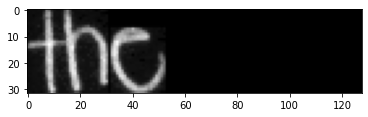



original_text =   a
predicted text = a

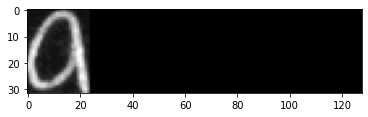



original_text =   on
predicted text = on

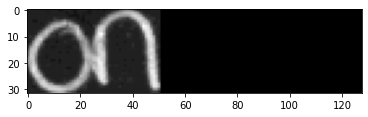



original_text =   members
predicted text = members

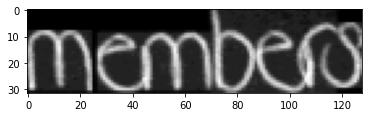

In [63]:
# predict outputs on validation images
i=502
j=506
prediction = act_model.predict(valid_images[i:j])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for _, x in enumerate(out):
    
    print("original_text =  ", valid_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    i+=1
    print('\n')

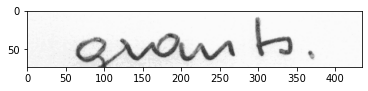

In [72]:
#Getting ROI
crop_img = img[y:y+h, x:x+w]
plt.imshow(crop_img)
# show ROI
#plt.imshow(roi)

predicted text = avntsr

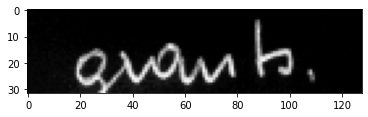

In [75]:
#Getting ROI
#for _, (x1,y1,x2,y2) in enumerate(lst):
#roi = img[y1:y2, x1:x2]
    
gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
process = process_image(gray)
reshaped = process.reshape(-1, 32, 128, 1)
prediction = act_model.predict(reshaped)

    # use CTC decoder
decoded = K.ctc_decode(prediction,input_length=np.ones(prediction.shape[0]) * prediction.shape[1],greedy=True)[0][0]

out = K.get_value(decoded)

    # see the results
for _, x in enumerate(out):

    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
plt.imshow(reshaped.reshape(32,128), cmap=plt.cm.gray)
plt.show()
i+=1